# Model Build

In [1]:

import os
import numpy as np
from typing import Any
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import metrics
from pandas import DataFrame
from metrics import plot_confusion
from IPython.display import Image
from tensorflow.keras import models
from keras.utils import plot_model
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from data import load_data
from wordcloud import WordCloud
import seaborn as sns
import umap

In [2]:
from sklearn.metrics import pairwise
def pairwise_sqd_distance(X, batch_size):
    return pairwise.pairwise_distances(X, metric='sqeuclidean')

    tiled = tf.tile(tf.expand_dims(X, axis=1), tf.stack([1, batch_size, 1]))
    tiled_trans = tf.transpose(tiled, perm=[1,0,2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

    return sqd_dist_mat

def make_q(z, batch_size, alpha):

    sqd_dist_mat = np.float32(pairwise_sqd_distance(z, batch_size))
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / tf.reduce_sum(q, axis=0, keepdims=True)
    # q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)
    
    return q

In [3]:
from linear_assignment import linear_assignment

def cluster_acc(y_true, y_pred, y_pred_cluster):
    y_true = y_true.astype(np.int64)
    assert y_pred_cluster.size == y_true.size
    D = max(y_pred_cluster.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred_cluster.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    c_loss = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred_cluster.size
    print(f"Cluster Loss {c_loss} on {y_pred_cluster.size} clusters")
    return c_loss

In [4]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import mixture
from scipy.stats import multivariate_normal

def do_clustering(clustering: str, n_clusters: int, z_state: DataFrame, params={}):
    """
    Perform clustering on the data.
        -clustering: the clustering algorithm to use
        -n_clusters: the number of clusters to use
        -z_state: the data to cluster
        -params: dict, optional
            'eps' or 'min_samples' values for DBSCAN/OPTICS
    Returns:
        - the cluster assignments
        - cluster centers
    """
    dbscan_eps = 1
    dbscan_min_samples = 5
    
    if 'eps' in params:
        dbscan_eps = params['eps']
    if 'min_samples' in params:
        dbscan_min_samples = params['min_samples']

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
            n_components=n_clusters, covariance_type='full')
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
        # get centres
        centers = np.empty(shape=(gmix.n_components, z_state.shape[1]))
        for i in range(gmix.n_components):
            density = multivariate_normal(
                cov=gmix.covariances_[i],
                mean=gmix.means_[i]).logpdf(z_state)
            centers[i, :] = z_state[np.argmax(density)]
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(z_state)
        centers = kmeans.cluster_centers_
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(
            eps=dbscan_eps,
            min_samples=dbscan_min_samples,
            metric='manhattan')
        y_pred = dbscan.fit_predict(z_state)
        centers = dbscan.components_
    elif clustering == 'OPTICS':
        optics = OPTICS(min_samples=dbscan_min_samples)
        y_pred = optics.fit_predict(z_state)
        centers = optics.components_
    elif clustering=="agg":
        agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='average')
        y_pred = agg.fit_predict(z_state)
        centers = None
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    return y_pred, centers

In [5]:
# write_messages.py

from jinja2 import Environment, FileSystemLoader
from pathlib import Path

def write_results_page(clusters, save_dir, test_name):
    
    environment = Environment(loader=FileSystemLoader("templates/"))
    template = environment.get_template("index.jinja")

    results_filename = os.path.join(save_dir, "index.html")
    results_template = environment.get_template("index.jinja")
    context = {
        "clusters": clusters,
        "test_name": test_name,
    }
    with open(results_filename, mode="w", encoding="utf-8") as results:
        results.write(results_template.render(context))
        full_filename = Path(results_filename).absolute()
        print (f'... wrote results  <a href="{full_filename}">{full_filename}</a>')

In [6]:
def show_wordcloud(i: int, cluster: dict, filepath: str, width: int=16, save_only: bool=False)-> None:
    """
    Show wordcloud for a cluster.
    """
    freqs = cluster['freqs']
    frac = cluster['frac']
    n = cluster['n']
    name = cluster['name']
    print(f'{i}: "{name}", {n} items, ({frac*100:.2f}% confidence)')
    if len(freqs) > 0:
        wc = WordCloud(width=800, height=500).generate_from_frequencies(freqs)
        if not save_only:
            plt.figure(figsize=(width, width-1))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        wc.to_file(filepath)
    else:
        print(f"No words for cluster {cluster}")

In [7]:
from pickletools import optimize
from tabnanny import verbose
from unicodedata import name
import warnings 
warnings.filterwarnings("ignore")

ENTITY_FILTER_LIST = ['GPE', 'PERSON', 'ORG', 'DATE', 'NORP',
    'TIME', 'PERCENT', 'LOC', 'QUANTITY', 'MONEY', 'FAC', 'CARDINAL',
    'EVENT', 'PRODUCT', 'WORK_OF_ART', 'ORDINAL', 'LANGUAGE']

class DeepLatentCluster():

    def __init__(
                self,
                run_name: str,
                config: dict=None,
                verbose: int=1,
                ):

        
        self.x = None
        self.y = None
        self.mapping = None
        self.strings = None
        self.y_pred_last = None
        self.input_dim = 768
        self.batch_size = 256
        
        self.run_name = run_name
        self.model = None
        self.encoder = None
        self.autoencoder = None
        self.save_dir = None
        self.verbose = verbose
        
        # latent model config
        self.config = {
            "layers_ae": [
                {"n": 500, "act": None},
                {"n": 500, "act": None},
                {"n": 2000, "act": None},
            ],
            "layer_ae_latent": 
                {"n": 40, "act": None},
            "layers_latent_network": [
                {"n": 2000, "act": None},
                {"n": 500, "act": None},
                {"n": 500, "act": None},
            ],
            "output_fn": 'sigmoid',
            "opt": k.optimizers.Adam(
                                lr=0.001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=None,
                                decay=0.0,
                                amsgrad=False),
            "loss": k.losses.binary_crossentropy,
            "train_size": 10000,
            "num_clusters": 25,
            "cluster": "GMM",
            "entities": None,
            "entity_count": 10,
            "loss_weights": None,
            "latent_weight": 0.0001,
            "reconstr_weight": 1.0,
            "max_iter": 8000,
            "pretrain_epochs": 300,
            "emb_size": 768,
            "alpha1": 20,
            "alpha2":1,
            "ae_init_fn": VarianceScaling(
                                    mode='fan_in',
                                    scale=1. / 3.,
                                    distribution='uniform')
            }
        if config is not None:
            self.config = {**self.config, **config}
        if self.config['entities'] is not None and self.config['entity_count'] > 0:
            raise ValueError('entities and entity_count cannot both be specified')
        if self.config['entities'] is None:
            if self.config['entity_count'] == 0:
                self.config['entities'] = ENTITY_FILTER_LIST
            else:
                self.config['entities'] = ENTITY_FILTER_LIST[
                                            :self.config['entity_count']]
                

    def output(self, s:str)->None:
        if self.verbose > 0:
            print(s)

    def make_data(self, oversample: bool=True) -> None:
        
        self.output("Load Data")
        self.x, self.y, self.mapping, self.strings = load_data(
                                    self.config['train_size'],
                                    entity_filter=self.config['entities'],
                                    get_text=True,
                                    oversample=oversample,
                                    verbose=self.verbose)
        self.input_dim = self.x.shape[1]
        self.output("Data Loaded")   

    

    def test_loss(self, y, y_pred):
        return cluster_loss(self.cluster, self.num_clusters)(y, y_pred)

    # create a Dense layer from a config
    @staticmethod
    def create_layer(config: dict, name: str, init_fn: str='glorot_uniform') -> Dense:
        """
        Create a layer from a config dictionary.
        - config: dictionary of layer parameters
            - n: number of units
            - act: activation function
        """
        print(f"Layer {name}: {config['n']} "
              f"activation={config['act']}")
        return Dense(
            name=name,
            units=config["n"],
            activation=config["act"],
            kernel_initializer=init_fn,
            kernel_regularizer='l1')

    # build the autoencoder

    def autoencoder_model(self, layer_specs: list, act: str='tanh', init_fn: str='glorot_uniform', verbose=0):
        """
        Creates the autoencoder given
        -layer_specs: list of layer sizes.
            Model is symmetrical so only need to specify the first half.
        -act: activation function for hidden layers
        -init_fn: initializer for weights

        returns:
            - the full autoencoder
            - the encoder only
        """
        layers = len(layer_specs) - 1
        # input
        input_img = Input(shape=(layer_specs[0],), name='input')
        x = input_img
        encoder = [input_img]
        # hidden layers in encoder
        for i in range(layers-1):
            layer = Dense(
                layer_specs[i + 1],
                activation=act,
                kernel_initializer=init_fn,
                name=f'encoder_{i}')(encoder[-1])
            encoder += [layer]
            if verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i+1]} '
                    f'activation={act}')

        # latent layer
        latent = Dense(
            layer_specs[-1],
            kernel_initializer=init_fn,
            name=f'encoder_{layers - 1}')(encoder[-1])
        encoder += [latent]
        if verbose >= 2:
            print(f'encoder_{layers - 1}: {layer_specs[-1]}')

        autoencoder = [encoder[-1]]
        # hidden layers in decoder
        for i in range(layers-1, 0, -1):
            layer = Dense(
                layer_specs[i],
                activation=act,
                kernel_initializer=init_fn,
                name=f'decoder_{i}')(autoencoder[-1])
            autoencoder += [layer]
            if verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i]}'
                    f' activation={act}')

        # output
        layer = Dense(
                layer_specs[0],
                kernel_initializer=init_fn,
                name='decoder_0')(autoencoder[-1])
        autoencoder += [layer]
        if verbose >= 2:
                print(f'output: {layer_specs[0]}'
                    f'')
        return (encoder, autoencoder)


    
    # create the latent_space model

    def create_latent_space_model(self, input_layer: Dense) -> Model:
        """
        Create the model for the latent space
        - input_layer: previous model output layer
        """
        # build ml, the array of layers
        ml = [input_layer]
        layers = self.config['layers_latent_network']
        for n, l in enumerate(layers):
            ml.append(self.create_layer(l, f"latent_{n}")(ml[-1]))

        out_config = {**layers[0], "act": self.config['output_fn']}
        ml.append(self.create_layer(out_config, "latent_out")(ml[-1]))
        return ml

    def create_model(self) -> Model:
        """
        Create the entire model.
        
        """
        print("Autoencoder")
        # enc = self.create_ae_encoder_model()
        # dec = self.create_ae_decoder_model(
        #     input_layer=enc[-1])

        enc, dec = self.autoencoder_model(
            [768, 500, 500, 2000, 40], 
            init_fn=self.config['ae_init_fn'], 
            act='relu',
            verbose=self.verbose)
        print("Latent Model")

        latent_space = self.create_latent_space_model(
            input_layer=enc[-1])
        self.model = k.Model(
            name="full-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
                latent_space[-1],
                ])
        
        self.autoencoder = k.Model(
            name="ae-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
                ])

        self.encoder = k.Model(
            name="encoder",
            inputs=enc[0],
            outputs=[
                enc[-1],
                ])


    def make_model(self) -> None:
        self.create_model()
        
        self.model.compile(
            loss=[
                self.latent_loss(
                        self.model.get_layer("encoder_2").get_weights()[0])],
            # loss_weights=self.config['loss_weights'],
            optimizer=SGD(learning_rate=0.5, momentum=0.9))
        self.output("model compiled")

        self.autoencoder.compile(optimizer='adam', loss='mse')
        
        self.save_dir = f'./results/{self.run_name}'
        if not os.path.exists(self.save_dir):
            # create save dir
            os.makedirs(self.save_dir)
        img_file = os.path.join(self.save_dir, f'{self.run_name}_model.png')
        plot_model(self.model, to_file=img_file, show_shapes=True)
        Image(filename=img_file)

    def reconstr_loss(self, x, x_pred):
        return tf.reduce_mean(tf.square(tf.subtract(x, x_pred)))

    def latent_loss(self, z_enc):
        def loss (y, y_pred):
            p = make_q(y_pred, self.batch_size, alpha=self.config['alpha1'])
            q = make_q(z_enc, self.batch_size, alpha=self.config['alpha2'])
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))
            return latent_loss
        return loss

    def train_model(self, verbose:int=1) -> None:
        """
        Run the model.
        """
        if verbose:
            self.verbose = verbose
            
        if self.x is None:
            self.make_data(oversample=True)
            self.output("Data Loaded")   
        
        if self.model is None:
            self.make_model()
        

        self.output("Training autoencoder")
        early_stopping_cb = EarlyStopping(
            monitor='loss', patience=10, verbose=1, min_delta=0.00001)
        history = self.autoencoder.fit(
                                self.x,
                                self.x,
                                batch_size=self.batch_size,
                                epochs=self.config["pretrain_epochs"], 
                                verbose=self.verbose,
                                callbacks=[early_stopping_cb],
                                )
        self.autoencoder.save_weights(os.path.join(self.save_dir, 'ae_weights.h5'))
        self.output("Trained autoencoder")
        if self.verbose > 0:
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.title('Autoencoder pretraining loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show()

        # # init cluster centres before train
        # self.init_cluster_centers()

        # train full model
        losses = self.train()
        if self.verbose > 0:
            # summarize history for loss
            plt.plot(losses)
            plt.title('Full model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show()

        print("Training Done")

    def aux_target_distribution(self, q):
        #sum column wise
        row_sum = q.sum(axis=0)
        # q_ij ^2 / row sum
        top = q ** 2 / row_sum
        # then / column sum
        return (top.T / top.sum(axis=1)).T

    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            dec, lat = self.model(x, training=True)
            loss_l =  self.latent_loss(self.encoder(x))(y, lat)
            loss_r = self.reconstr_loss(x, dec)
            loss_value = self.config['latent_weight'] * loss_l +\
                         self.config['reconstr_weight'] * loss_r

            # Add any extra losses created during the forward pass.
            # loss_value += sum(self.losses)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer = self.config['opt']
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, lat)
        return loss_value
        
    def train(self):
        self.train_acc_metric = k.metrics.SparseCategoricalAccuracy()

        update_interval = 140
        index_array = np.arange(self.x.shape[0])
        tol = 0.0001  # tolerance threshold to stop training
        loss = 0
        index = 0
        update_interval = 140
        losses = []
        for ite in range(int(self.config['max_iter'])):
            if ite % update_interval == 0:
                print(f"Iter:{ite} -> loss:{loss}")
            idx = index_array[
                    index * self.batch_size : 
                    min((index+1) * self.batch_size , self.x.shape[0])]
            loss = self.train_step(self.x[idx], self.y[idx])
            losses += [loss]
        if self.verbose == 0:
            # final values
            print(f'Iter: {ite} loss={loss}')
        self.model.save_weights(os.path.join(self.save_dir, 'lat_model_final.h5'))
        return losses

    def cluster_pred_acc(self):
        NER_only= DataFrame({'y':self.y, 'y_clus':self.y_pred})
        unk_tuple = [k for k, v in self.mapping.items() if v == 'UNKNOWN']
        unk_idx = unk_tuple[0] if len(unk_tuple) > 0 else None
        NER_only.drop(NER_only.index[NER_only['y']==unk_idx], inplace=True)
        NER_match = NER_only[NER_only['y']==NER_only['y_clus']]
        # fraction that match
        frac = NER_match.shape[0]/NER_only.shape[0]
        return frac

    def make_load_model(self):
        self.make_model()

        ae_weights_file = os.path.join(self.save_dir, 'ae_weights.h5')
        self.output(f"Loading AE weights from {ae_weights_file}")
        self.autoencoder.load_weights(ae_weights_file)
        
        model_weights_file = os.path.join(self.save_dir, 'lat_model_final.h5')
        self.output(f"Loading model weights from {model_weights_file}")
        self.model.load_weights(model_weights_file)

    
    def evaluate_model(self, eval_size: int, verbose:int=1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        if self.config['train_size'] != eval_size or self.x is None:
            self.output("Load Data")
            self.x, self.y, self.mapping, self.strings = load_data(
                                                            eval_size,
                                                            get_text=True,
                                                            verbose=verbose)
            self.output("Data Loaded")   

        self.make_load_model()
        
        
        # predict cluster labels
        self.output("Predicting...")
        
        # run the model on sampled x in batches
        num_batches = len(self.x) // self.batch_size
        z_list = []
        for i in tqdm(range(num_batches)):
            idx = np.arange(i * self.batch_size, (i + 1) * self.batch_size)
            x = self.x[idx]
            _, z = self.model.predict(x)
            z_list += [z]

        z_space =  np.vstack(np.array(z_list))
        if z_space.shape[0] > 10000:
            indices = np.random.choice(z_space.shape[0], 1000, replace=False)
            z_sample = z_space[indices]
            labels = self.y[indices]
        else:
            z_sample = z_space.shape
            labels = self.y
        
        print(f"Clustering {z_sample.shape[0]} points")
        self.y_pred, _ = do_clustering(
                                clustering="GMM",
                                n_clusters=self.config['num_clusters'],
                                z_state=z_sample)

        labels = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in labels ])
        mapper = umap.UMAP(metric='manhattan').fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=labels)


        # confusion matrix
        cm_width = max(8, len(np.unique(self.y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(self.y, self.y_pred, self.mapping, self.save_dir, cm_width)

        # show wordclouds for each cluster
        self.output ("CLUSTERS")
        clusters = {}
        predicted = DataFrame({
            'text':self.strings,
            'y_pred':self.y_pred,
            'y_true':self.y})
        for cluster_no in tqdm(range(self.num_clusters)):
            y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
            true_label = 'UNKNOWN'
            modal_value = y_pred_for_key['y_true'].mode()
            if len(modal_value)>0:
                if modal_value[0] in self.mapping:
                    true_label = self.mapping[modal_value[0]]
                # confidence - fraction of this cluster that is actually this cluster
                y_true_this_cluster = len(
                    y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
                frac = y_true_this_cluster/len(y_pred_for_key)
            else:
                frac = 0

            # wordcloud
            unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
            freq_list = np.asarray((unique, counts)).T
            freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
            freqs = {w: f for w,f in freq_list}
            entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
            if true_label == 'UNKNOWN':
                clusters[f"UNK-{cluster_no}"] = entry
            elif true_label in clusters:
                if clusters[true_label]['frac'] < frac:
                    # we found a better cluster for this label
                    clusters[true_label] = entry
                else:
                    # this cluster is worse than this one, so it's unknown
                    clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
            else:
                clusters[true_label] = entry

        cluster_list = [{
            **clusters[c],
            'name': c,
            'idx': idx} for idx, c in enumerate(clusters)]
        cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

        display_list = []
        # show unknown clusters first
        for i, cluster in enumerate(cluster_list):
            if cluster['name'][0:3] == "UNK":
                save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}.png")
                show_wordcloud(i, cluster, save_file, save_only=True)
                display_list.append(cluster)

        # next show known clusters
        for i, cluster in enumerate(cluster_list):
            if cluster['name'][0:3] != "UNK":
                save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}.png")
                show_wordcloud(i, cluster, save_file, save_only=True)
                display_list.append(cluster)

        
        self.output(write_results_page(display_list, self.save_dir, self.run_name))


    def visualise_tsne(self):
        tsne = TSNE(
                n_components=2,
                verbose=1,
                random_state=123,
                n_iter=300,
                learning_rate='auto')
        x_enc = self.encoder.predict(self.x)
        z = tsne.fit_transform(x_enc)
        df_tsne = pd.DataFrame()
        df_tsne["y"] = self.y_pred
        df_tsne["comp-1"] = z[:,0]
        df_tsne["comp-2"] = z[:,1]
        plt.figure(figsize=(18,14))
        sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.y.tolist(),
                palette=sns.color_palette(
                        "hls",
                        len(ENTITY_FILTER_LIST)),
                data=df_tsne).set(title="Labelled embeddings T-SNE projection") 

    
    def visualise_umap(self, sample:int=1000, embs:str="z"):
        if embs == "z":
            # encoder output
            z_enc = self.encoder.predict(self.x)
        elif embs == "x":
            # raw BERT embeddings
            z_enc = self.x
        indices = np.random.choice(z_enc.shape[0], sample, replace=False)
        labels = self.y_pred[indices]
        labels = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in labels ])
        z_sample = z_enc[indices]
        mapper = umap.UMAP(metric='manhattan').fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=labels)
        umap.plot.plt.show()
    
    
    

    def train_and_evaluate_model(self, eval_size, verbose=1):
        """
        Make and evaluate a model.
        Arguments:
            run_name: name of the run.
            data_rows: number of rows to use.
            n_clusters: number of clusters to use.
            entity_count: number of entities to use.
        """
        self.verbose = verbose
        self.make_model()
        self.train_model()
        self.evaluate_model(eval_size)

In [8]:
del dc

NameError: name 'dc' is not defined

In [8]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster('test-latent', 
                      {
                        'train_size':1000,
                        'reconstr_weight':1.0, 'latent_weight':1e-5})
dc.make_model()
print(dc.autoencoder.summary())


Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Model: "ae-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 40)                80040     
                                                                 

In [11]:
dc.make_data()
dc.train_model(verbose=0)


Load Data
Loading ./data/conll_spacy_1000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 9: 'DATE', 5: 'GPE', 6: 'LOC', 13: 'QUANTITY', 11: 'PERCENT', 8: 'EVENT', 12: 'MONEY', 3: 'NORP', 14: 'ORDINAL', 16: 'FAC', 10: 'TIME', 15: 'CARDINAL', 7: 'PRODUCT'}
Done: (658, 772)
Train data balance:
[[  2 153]
 [  3   7]
 [  4 122]
 [  5 249]
 [  6   7]
 [  9 103]
 [ 10   2]
 [ 11   3]
 [ 12   7]
 [ 13   5]]
Balancing data
x: (2490, 768), y: (2490,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Training autoencoder
Epoch 1/300
10/10 [==============================] - 1s 19ms/step - loss: 0.1376
Epoch 2/300
10/10 [==============================] - 0s 8ms/step - loss: 0.1264
Epoch 3/300
10/10 [==============================] - 0s 2ms/step - loss: 0.0970
Epoch 4/300
10/10 [==============================] - 0s 2ms/step - loss: 0.0891
Epoch 5/300
10/10 [==============================] - 0s 2ms/step - loss: 0.0847
E

KeyboardInterrupt: 

Load Data
Loading ./data/conll_spacy_1000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 9: 'DATE', 5: 'GPE', 6: 'LOC', 13: 'QUANTITY', 11: 'PERCENT', 8: 'EVENT', 12: 'MONEY', 3: 'NORP', 14: 'ORDINAL', 16: 'FAC', 10: 'TIME', 15: 'CARDINAL', 7: 'PRODUCT'}
Done: (3348, 772)
Train data balance:
[[   1 2672]
 [   2  153]
 [   3    7]
 [   4  122]
 [   5  249]
 [   6    7]
 [   7    1]
 [   8    5]
 [   9  103]
 [  10    2]
 [  11    3]
 [  12    7]
 [  13    5]
 [  14    3]
 [  15    1]
 [  16    8]]
Balancing data
x: (42752, 768), y: (42752,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'DATE', 9: 'TIME', 10: 'PERCENT', 11: 'MONEY', 12: 'QUANTITY', 13: 'ORDINAL', 14: 'CARDINAL', 15: 'FAC'}
Data Loaded
Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Loading AE weights from ./results/test-latent\

  0%|          | 0/167 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step
Clustering 1000 points


ValueError: Found input variables with inconsistent numbers of samples: [42752, 1000]

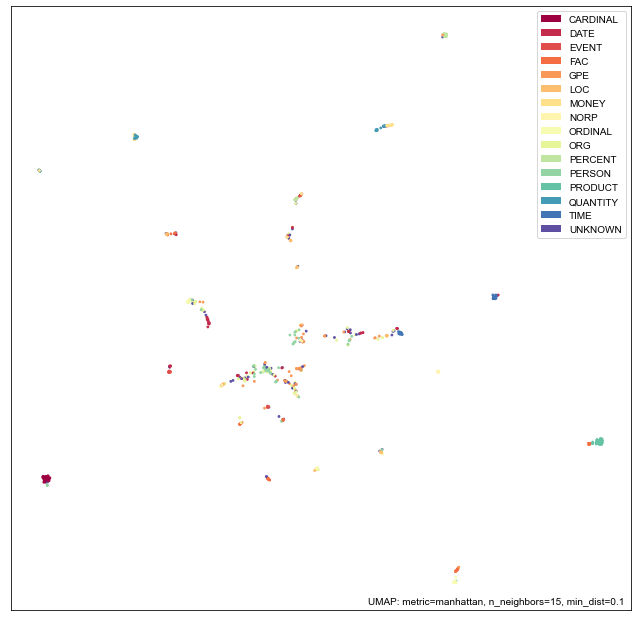

In [9]:
dc.evaluate_model(1000)

In [ ]:
stop

NameError: name 'stop' is not defined

# Evaluate

In [ ]:
# %history -g -f jupyter_history.py


In [ ]:
del dc

In [ ]:
dc = DeepCluster('test-0-40latent-q', dims=[768, 500, 500, 2000, 40],
    entity_count=10, train_size=0, num_clusters=25, maxiter=10000)
dc.train_and_evaluate_model(10000, verbose=1)

In [ ]:
dc = DeepCluster('test-0-40latent', dims=[768, 500, 500, 2000, 40],
    entity_count=10, train_size=0, num_clusters=25, maxiter=2000)
dc.train_and_evaluate_model(10000, verbose=1)

In [ ]:
dc = DeepCluster('test-0-40latent', dims=[768, 500, 500, 2000, 40],
    entity_count=10, train_size=0, num_clusters=25, maxiter=2000)
dc.train_and_evaluate_model(10000, verbose=1)

In [ ]:
dc = DeepCluster('test-0-40latent', dims=[768, 500, 500, 2000, 40],
    entity_count=10, train_size=0, num_clusters=25, maxiter=2000)
dc.evaluate_model(10000, verbose=0)
print("UMAP")
dc.visualise_umap(5000, embs="x")
dc.visualise_umap(5000, embs="z")

In [ ]:

dc = DeepCluster('test-0-100latent', dims=[768, 500, 500, 2000, 100],
    entity_count=10, train_size=0, num_clusters=25, maxiter=1000)
dc.train_and_evaluate_model(10000, verbose=1)

In [ ]:
dc = DeepCluster('test-0-250latent', dims=[768, 500, 500, 2000, 250],
    entity_count=10, train_size=0, num_clusters=25, maxiter=1000)
dc.train_and_evaluate_model(10000, verbose=1)

In [ ]:

dc.visualise_tsne()

In [ ]:
dc = DeepCluster('test1', train_size=0, num_clusters=25).train_and_evaluate_model(10000)

In [ ]:
# %history -g -f jupyter_history3.py

In [ ]:
make_data(10000, oversample=False)
"Done"

In [ ]:
dc = DeepCluster('test-0', entity_count=10, train_size=0, num_clusters=25).train_and_evaluate_model(10000)


In [ ]:
train_and_evaluate_model('test-none-3k', train_size=3000, eval_size=10000, n_clusters=25, entity_count=10)


In [ ]:
model = evaluate_model('test-none-3k', eval_size=10000, n_clusters=25)


In [ ]:

serialise_model(model, 'test-none-3k')

In [ ]:
models.load_model('./results/test-none-3k')

In [ ]:
train_model('test-none-10k', train_size=10000, n_clusters=25, entity_count=10)


In [ ]:
evaluate_model('test-none-10k', eval_size=10000, n_clusters=25)


In [ ]:
evaluate_model('test-none-30', train_size=30, eval_size=1000, n_clusters=25)


In [ ]:
train_and_evaluate_model('test3', train_size=1000, eval_size=10000, n_clusters=25, entity_count=10)


In [ ]:
train_and_evaluate_model('test1', train_size=10000, eval_size=10000, n_clusters=25, entity_count=0)

In [ ]:
train_and_evaluate_model('test1-2', train_size=10000, eval_size=10000, n_clusters=25, entity_count=0)

In [ ]:
evaluate_model('test1-2', eval_size=10000, n_clusters=25, include_unclass=True)

In [ ]:
train_model('test1', cluster="GMM", data_rows=1000, entity_count=0, n_clusters=20 )

In [ ]:
train_model('test1', cluster="GMM", data_rows=1000, entity_count=0, n_clusters=20 )


In [ ]:
evaluate_model('test1', data_rows=1000, n_clusters=20 )

In [ ]:
evaluate_model('test1', data_rows=1000, entity_count=0, n_clusters=20 )

In [ ]:
train_and_evaluate_model('test2', train_size=10000, eval_size=10000, n_clusters=15, entity_count=10)

In [ ]:
train_model('reset-metrics', cluster='Kmeans', data_rows=1000, entity_count=0, n_clusters=20 )


In [ ]:
train_model('reset-metrics', cluster='Kmeans', data_rows=10000, entity_count=10, n_clusters=15 )


In [ ]:
train_model('reset-metrics-dbscan', cluster="DBSCAN", data_rows=1000, entity_count=0, n_clusters=20 )


In [ ]:
train_model('reset-metrics-dbscan', cluster="DBSCAN", data_rows=1000, entity_count=10, n_clusters=15)


In [ ]:
train_model('reset-metrics-dbscan', cluster="OPTICS", data_rows=1000, entity_count=0, n_clusters=20 )

In [ ]:
train_model('reset-metrics-optics', cluster="OPTICS", data_rows=1000, entity_count=10, n_clusters=15 )


In [ ]:
evaluate_model('reset-metrics-dbscan',
        entity_count=10,
        data_rows=1000,
        n_clusters=20,
        cluster="DBSCAN",
        )

# benchmark

In [ ]:
# optimal eps https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

from sklearn.neighbors import NearestNeighbors

def optimal_eps(X, n_neighbors=10):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [ ]:
def cluster_score(y, y_pred, n_clusters):
    """
    Compute the cluster score.
    Arguments:
        y: true labels.
        y_pred: predicted labels.
        n_clusters: number of clusters.
    Returns:
        cluster score.
    """
    # compute the cluster score
    score = 0
    for i in range(n_clusters):
        score += np.sum(y_pred[y==i]==i)
    return score/len(y)

In [ ]:
def hypertune_density_clustering():
    """
    hypertune the density clustering algorithms.
    """
    eps_vals = [30000.0, 40000.0, 50000.0]
    x, y, mapping, strings = load_data(
                                    1000,
                                    oversample=True,
                                    get_text=True)
    print(f"Optimal epsilon: {optimal_eps(x)}")
    for eps in eps_vals:
        # predict cluster labels
        print(f"Predicting...for epsilon={eps}")
        y_pred, _ = do_clustering('DBSCAN', 25, x, params={'eps':eps})
        print(f"ACC: {cluster_score(y, y_pred, 25)}")
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y, y_pred, mapping, size=cm_width, save_dir=None, details=False)

In [ ]:
hypertune_density_clustering()

In [ ]:
def run_benchmark(cluster:str, eval_size:int, n_clusters:int):
    x, y, mapping, strings = load_data(
                                    eval_size,
                                    oversample=False,
                                    get_text=True)
    save_dir = f'./results/bm/{cluster}'
    if not os.path.exists(save_dir):
        # create save dir
        os.makedirs(save_dir)

    
    # predict cluster labels
    print("Predicting...")
    y_pred, _ = do_clustering(cluster, n_clusters, x)
    # print(f"ACC: {cluster_acc(y, y_pred)}")
    
    # confusion matrix
    cm_width = max(8, len(np.unique(y_pred)) * 2)
    cm_width = min(16, cm_width)
    plot_confusion(y, y_pred, mapping, save_dir, cm_width)

    # show wordclouds for each cluster
    print ("BENCHMARK CLUSTERS")
    clusters = {}
    predicted = DataFrame({'text':strings, 'y_pred':y_pred, 'y_true':y})
    for cluster_no in range(n_clusters):
        y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
        true_label = 'UNKNOWN'
        modal_value = y_pred_for_key['y_true'].mode()
        if len(modal_value)>0:
            if modal_value[0] in mapping:
                true_label = mapping[modal_value[0]]
            # confidence - fraction of this cluster that is actually this cluster
            y_true_this_cluster = len(
                y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
            frac = y_true_this_cluster/len(y_pred_for_key)
        else:
            frac = 0

        # wordcloud
        unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w,f in freq_list}
        entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
        if true_label == 'UNKNOWN':
            clusters[f"UNK-{cluster_no}"] = entry
        elif true_label in clusters:
            if clusters[true_label]['frac'] < frac:
                # we found a better cluster for this label
                clusters[true_label] = entry
            else:
                # this cluster is worse than this one, so it's unknown
                clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
        else:
            clusters[true_label] = entry

    cluster_list = [{
        **clusters[c],
        'name': c,
        'idx': idx} for idx, c in enumerate(clusters)]
    cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

    display_list = []
    # show unknown clusters first
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] == "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    # next show known clusters
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] != "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    
    print(write_results_page(display_list, save_dir, cluster))

In [ ]:
run_benchmark('Kmeans', 10000, 25)

In [ ]:
run_benchmark('GMM', 10000, 25)

In [ ]:
run_benchmark('agg', 10000, 25)